In [2]:
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

# Paths
base_dir = "C:\\Users\\alikh\\OneDrive\\mlprojects\\agriculture pests image dataset"  # <-- CHANGE this to your pest dataset folder

# Image augmentation settings
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Target image count for all folders
target_count = 500

# Find image counts per folder
folder_counts = {}
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        folder_counts[folder] = len([f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))])

# Augment images where needed
for folder, count in folder_counts.items():
    folder_path = os.path.join(base_dir, folder)
    if count < target_count:
        images = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        images_needed = target_count - count
        print(f"Augmenting '{folder}' ({count} images) to reach {target_count} images...")

        for _ in range(images_needed):
            img_name = random.choice(images)
            img_path = os.path.join(folder_path, img_name)

            img = load_img(img_path)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            for batch in datagen.flow(x, batch_size=1):
                new_filename = f"aug_{random.randint(10000,99999)}_{img_name}"
                new_filepath = os.path.join(folder_path, new_filename)
                array_to_img(batch[0]).save(new_filepath)
                break  # Only one image generated per loop

print("\n✅ All folders are now balanced to 500 images each!")



✅ All folders are now balanced to 500 images each!


Augmenting 'ants' (499 images) to reach 500 images...
Augmenting 'beetle' (416 images) to reach 500 images...
Augmenting 'catterpillar' (434 images) to reach 500 images...
Augmenting 'earthworms' (323 images) to reach 500 images...
Augmenting 'earwig' (466 images) to reach 500 images...
Augmenting 'grasshopper' (485 images) to reach 500 images...
Augmenting 'moth' (497 images) to reach 500 images...
Augmenting 'slug' (391 images) to reach 500 images...
Augmenting 'wasp' (498 images) to reach 500 images...
Augmenting 'weevil' (485 images) to reach 500 images...

✅ All folders are now balanced to 500 images each!

In [3]:


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import os

# Set your image size and paths
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 12   # Change according to your number of pest categories
DATA_DIR = "C:\\Users\\alikh\\OneDrive\\mlprojects\\agriculture pests image dataset"  # Folder with subfolders per class (Ant, Bee, etc.)

# 1. Data Augmentation and Data Loading
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% train, 20% validation
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# 2. Load Pre-trained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'  # Use pre-trained on ImageNet
)

# Freeze the base model layers
base_model.trainable = False

# 3. Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 4. Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 5. Train the Model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

# 6. Save the Model
model.save('pest_identifier_mobilenetv2.h5')

print("Training Complete and Model Saved!")

Found 4800 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.
Epoch 1/15


c:\Users\alikh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.2001 - loss: 2.4907 - val_accuracy: 0.6725 - val_loss: 1.2721
Epoch 2/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.5882 - loss: 1.3603 - val_accuracy: 0.7433 - val_loss: 0.8891
Epoch 3/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - accuracy: 0.6689 - loss: 1.0437 - val_accuracy: 0.7858 - val_loss: 0.7165
Epoch 4/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.7326 - loss: 0.8692 - val_accuracy: 0.8017 - val_loss: 0.6432
Epoch 5/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.7540 - loss: 0.7982 - val_accuracy: 0.8092 - val_loss: 0.6026
Epoch 6/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.7574 - loss: 0.7446 - val_accuracy: 0.7942 - val_loss: 0.5859
Epoch 7/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.7822 - loss: 0.7067 - val_accuracy: 0.8092 - val_loss: 0.5582
Epoch 8/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.7797 - loss: 0.6750 - val_accuracy: 0.817

Training Complete and Model Saved!


In [4]:
# Unfreeze some layers of the base MobileNetV2 model
base_model.trainable = True

# OPTIONAL: Freeze very early layers if you want
# Fine-tuning only the last few layers is often better
for layer in base_model.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False

In [5]:
# Re-compile with a LOWER learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [6]:
# Fine-tune the model
history_finetune = model.fit(
    train_generator,
    epochs=5,   # 5 or 10 more fine-tuning epochs
    validation_data=validation_generator
)

Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.6897 - loss: 0.9672 - val_accuracy: 0.8383 - val_loss: 0.4811
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.7754 - loss: 0.6775 - val_accuracy: 0.8417 - val_loss: 0.4680
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.8052 - loss: 0.5963 - val_accuracy: 0.8433 - val_loss: 0.4797
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.8173 - loss: 0.5447 - val_accuracy: 0.8558 - val_loss: 0.4375
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.8211 - loss: 0.5314 - val_accuracy: 0.8533 - val_loss: 0.4174


In [10]:
# Save the fine-tuned model
model.save('pest_identifier_mobilenetv2_finetuned.h5')

print("Fine-tuning Complete and Model Saved!")

Fine-tuning Complete and Model Saved!


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Pest: Slug
Recommended Natural Pesticide: Iron Phosphate Pellets


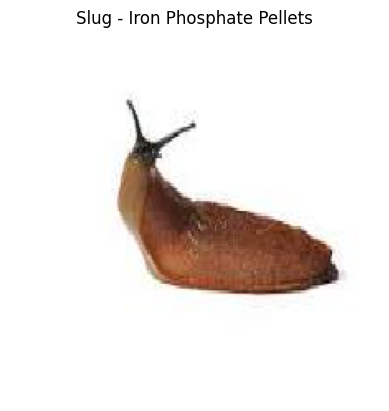

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load your fine-tuned model
model = tf.keras.models.load_model('pest_identifier_mobilenetv2_finetuned.h5')

# Load the pesticide CSV
pesticide_df = pd.read_csv("C:\\Users\\alikh\\OneDrive\\mlprojects\\agriculture pests image dataset\\natural_pesticides.csv")  # <- Replace with your actual CSV file name

# Make dictionary { pest_name: pesticide_name }
pest_to_pesticide = dict(zip(pesticide_df['Pest'], pesticide_df['Pesticide (Natural/Non-Harmful)']))

# Your class labels (ensure it matches model training order)
class_labels = [
    'ant', 'bees', 'beetle', 'catterpillar', 'earthworm', 
    'earwig', 'grasshopper', 'moth', 'slug', 'snail', 
    'wasp', 'weevil'
]

def predict_pest(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))  # MobileNetV2 expects 224x224
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    # Make prediction
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions[0])
    predicted_pest = class_labels[predicted_index]
    
    # Find corresponding pesticide
    pesticide = pest_to_pesticide.get(predicted_pest, "No pesticide found")

    # Show result
    print(f"Predicted Pest: {predicted_pest.capitalize()}")
    print(f"Recommended Natural Pesticide: {pesticide}")

    # Optionally display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{predicted_pest.capitalize()} - {pesticide}")
    plt.show()

# 5. Example Usage:
img_path = "C:\\Users\\alikh\\Downloads\\slug.jpg"# Replace with your image path
# Example usage
predict_pest(img_path)